# 01_contrastive_umap

For investigating contrastive embeddings, build interactive umaps and isolate compounds of interest

In [2]:
from pathlib import Path
import numpy as np
import pickle
from functools import partial
from collections import Counter
import pandas as pd
from sklearn.metrics.pairwise import  cosine_similarity


import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

import umap
import mpld3

from rdkit import Chem
from rdkit.Chem import Draw

from mist import utils
from mist.utils.plot_utils import *

set_style()

In [3]:
labels = pd.read_csv("../data/paired_spectra/csi2022/labels.tsv", sep="\t")
name_to_smi = dict(labels[["spec", "smiles"]].values)

In [4]:
embed_file = "../results/2022_10_30_embed_outputs/embeds/embed_csi2022_0.p"
save_name = None
smi_to_cls_f = "../data/unpaired_mols/bio_mols/new_smi_to_classes.p"
smi_to_cls = pickle.load(open(smi_to_cls_f, "rb"))

In [5]:
embeddings = pickle.load(open(embed_file,"rb"))
embeds, names = embeddings['embeds'], embeddings['names']

In [6]:
# Extract classes
classes = []
for name in names:
    superclasses = smi_to_cls[name]['superclass_results']
    if len(superclasses) == 0: 
        classes.append("Unknown")
    else:
        classes.append(np.random.choice(superclasses))

classes = np.array(classes)

In [9]:
# # Lower min dist and lwoer n neighbors makes it a ltitle more clumped
reducer = umap.UMAP(metric="cosine", min_dist=0.1, n_neighbors=15, spread=1.)
umap_embeds = reducer.fit_transform(embeds, )

In [11]:
# Calculate the order of classes
uniq_classes = list(set(classes))
num_classes = len(uniq_classes)

class_counts = Counter(classes)
top_class_order = np.argsort([class_counts[i] for i in uniq_classes])[::-1]

top_classes = np.array(uniq_classes)[top_class_order]

In [12]:
# Build plot gruops
k = 15
plot_groups = []
plot_group_names = []
for j in top_classes[:k]:
    inds = np.where(classes == j)[0]
    plot_groups.append(inds)
    plot_group_names.append(j)

In [13]:
# Build colors
colors = sns.color_palette("husl", n_colors=len(plot_groups))

In [14]:
plot_group_order = ["Unknown","Oligopeptides",  "Small peptides",  "Lysine alkaloids", 
                    "Tyrosine alkaloids", "Tryptophan alkaloids", "Nicotinic acid alkaloids", 
                    "Anthranilic acid alkaloids", "Ornithine alkaloids", "Pseudoalkaloids", "Flavonoids", 
                    "Coumarins",  "Steroids",  "Triterpenoids", "Sesquiterpenoids"]
priority_dict = dict(zip(plot_group_order, np.arange(len(plot_group_order))))
argsort_basis = [priority_dict.get(i, 100) for i in plot_group_names]
new_order = np.argsort(argsort_basis)
plot_groups = np.array(plot_groups, dtype=object)[new_order]
plot_group_names = np.array(plot_group_names)[new_order]

In [15]:
plot_group_names

array(['Unknown', 'Oligopeptides', 'Small peptides', 'Lysine alkaloids',
       'Tyrosine alkaloids', 'Tryptophan alkaloids',
       'Nicotinic acid alkaloids', 'Anthranilic acid alkaloids',
       'Ornithine alkaloids', 'Pseudoalkaloids', 'Flavonoids',
       'Coumarins', 'Steroids', 'Triterpenoids', 'Sesquiterpenoids'],
      dtype='<U26')

In [16]:
name_to_color = dict(zip(plot_group_names, colors)) 

# name_to_color['Unknown'] = "white"
name_to_alpha = {i: 0.9 for i in name_to_color}
name_to_alpha['Unknown'] = 0.7
name_to_edge_color = {i: "none" for i in name_to_color}
name_to_edge_color['Unknown'] = "#EFC7B8" #name_to_color['Unknown']
name_to_color['Unknown'] = "none"

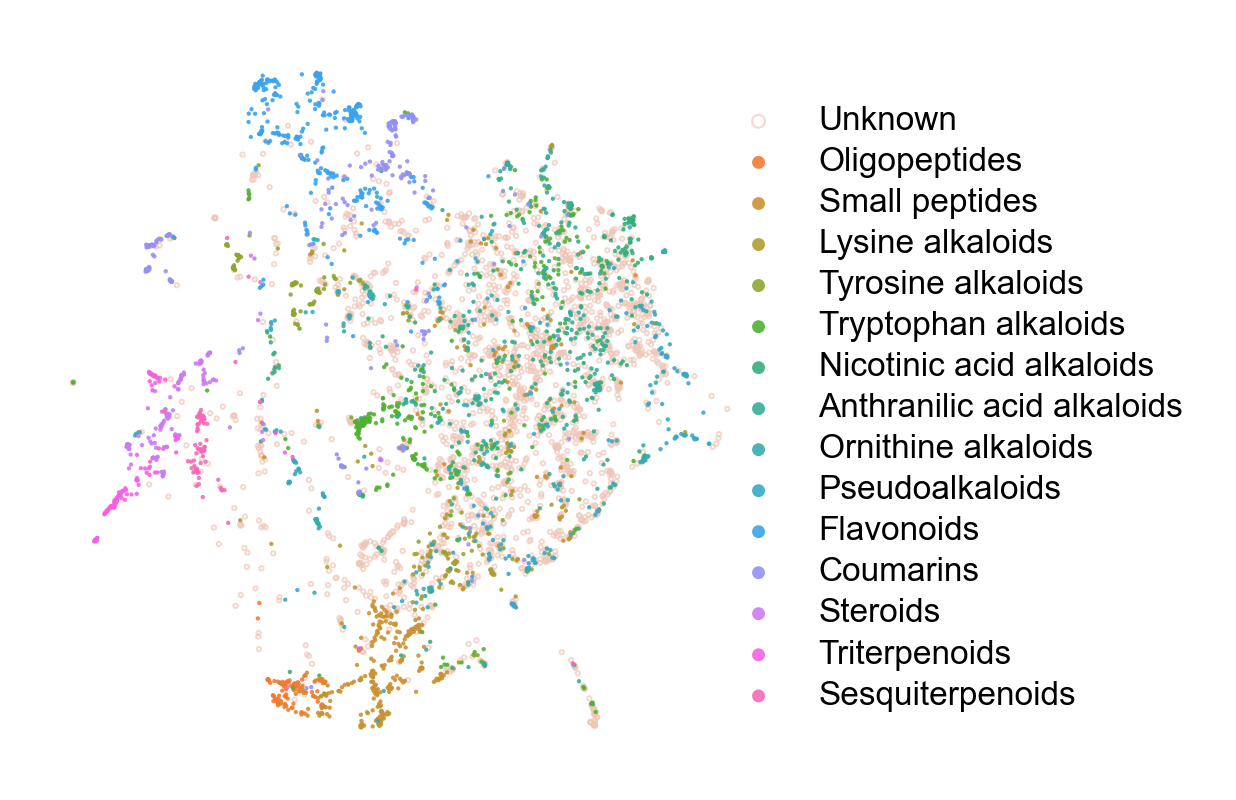

In [19]:
ax_sizes = (1.8, 1.8)
fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()
for inds, name in zip(plot_groups, plot_group_names):
    out = ax.scatter(umap_embeds[inds, 0], 
                     umap_embeds[inds, 1], 
                     label=name,
                     color=name_to_color[name],
                     facecolors=name_to_color[name],
                     edgecolors=name_to_edge_color[name],
                     s=0.6,
                     linewidth=0.35,
                     alpha=name_to_alpha[name]
                    )
    labels=[f"{i} ({name})" for i in inds]
ax.legend(loc="upper left",
          frameon=False, facecolor="none", fancybox=False,
          markerscale=3, bbox_to_anchor=(0.91, 0.95),  #bbox_to_anchor=(-0.5, 0.95)  , #
          ncol=1,
         labelspacing=0.3)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel("UMAP 1")
# ax.set_ylabel("UMAP 2")
ax.axis("off")
set_size(*ax_sizes)
# plt.tight_layout()
# mpld3.display()
fig.savefig("/Users/samgoldman/Desktop/umap_temp.png", dpi=400, bbox_inches="tight", transparent=True)

In [20]:
ax_sizes = (1.8, 1.8)
fig = plt.figure(figsize=ax_sizes, dpi=400)
ax = fig.gca()
for inds, name in zip(plot_groups, plot_group_names):
#     if name == "Unknown": continue
    out = ax.scatter(umap_embeds[inds, 0], 
                     umap_embeds[inds, 1], 
                     label=name,
                     color=name_to_color[name],
                     facecolors=name_to_color[name],
                     edgecolors=name_to_edge_color[name],
                     s=0.2,
                     linewidth=0.5,
                     alpha=name_to_alpha[name]
                    )
    labels=[f"{i} ({name})" for i in inds]
    tooltip = mpld3.plugins.PointLabelTooltip(out, labels=labels)
    mpld3.plugins.connect(fig, tooltip)

ax.set_xticks([])
ax.set_yticks([])
ax.axis("off")
plt.tight_layout()
mpld3.display()

CCMSLIB00006706556 (3578, Small peptides): CCOC(=O)C(CC1=CNC2=CC=CC=C21)NC(=O)COC3=CC=C(C=C3)Br
CCMSLIB00006705779 (2825, Unknown): CC1=C(C=C(O1)C2=CC=CC=C2)C(=O)NC(CC3=CNC4=CC=CC=C43)C(=O)O


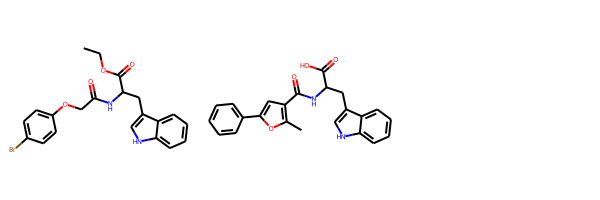

In [43]:
inds = [3578, 2825]
sub_names = names[inds]
smis = [name_to_smi[i] for i in sub_names]
for i,j, k in zip(smis, sub_names, inds): print(f"{j} ({k}, {classes[k]}): {i}")
Draw.MolsToGridImage([Chem.MolFromSmiles(i) for i in smis])

CCMSLIB00000080546 (4853, Coumarins): C1CN(CCC1C(=O)O)C(=O)COC2=CC3=C(C=C2)C4=CC=CC=C4C(=O)O3
CCMSLIB00000080108 (55, Coumarins): C1CN(CCC1C(=O)N)C(=O)COC2=CC3=C(C=C2)C4=CC=CC=C4C(=O)O3
CCMSLIB00000080187 (5164, Coumarins): CC1=CC(=O)OC2=C1C=CC(=C2)OCC(=O)N3CCC(CC3)C(=O)N
CCMSLIB00006701182 (4702, Unknown): CCOC1=CC=CC(=C1O)C2C3C(C(=O)N(C3=O)C4=CC=CC=C4OC)C(N2)(C)C(=O)O
CCMSLIB00000080137 (4339, Unknown): COC1=C(C(=C(C=C1)C=C2C(=O)C3=C(O2)C=C(C=C3)OCC(=O)N4CCC(CC4)C(=O)O)OC)OC


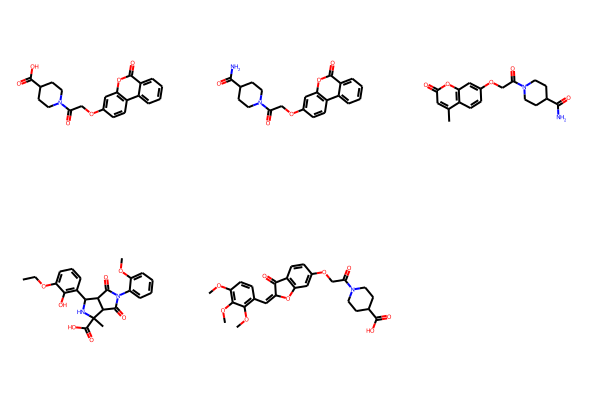

In [54]:
inds = [4853, 55, 5164, 4702, 4339]

sub_names = names[inds]
smis = [name_to_smi[i] for i in sub_names]
for i,j, k in zip(smis, sub_names, inds): print(f"{j} ({k}, {classes[k]}): {i}")
Draw.MolsToGridImage([Chem.MolFromSmiles(i) for i in smis])